В этом ноутбуке:
*  будем сравнивать KNN и логистическую регрессию на реальных данных
*  будем пробовать классические подходы в ML:
  - кросс-валидация
  - class_weights
  - GridSearch
  - feature engineering
  - pipelines


In [1]:
# подключить библиотеки
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
# считать данные
data = pd.read_csv('ClientsData.csv')

In [3]:
data.head()

,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_DLQ_NUM,TARGET
0,49,1,0,1,2,1,5000.0,1,1,2,0
1,32,1,0,1,3,3,12000.0,1,1,1,0
2,52,1,0,1,4,0,9000.0,2,1,0,0
3,39,1,0,1,1,1,25000.0,1,1,3,0
4,30,1,0,0,0,0,12000.0,2,1,2,0


In [4]:
data.shape

(15223, 11)

В этом ноутбуке нам придется подбирать гиперпараметры модели, а ещё и порог, поэтому чтобы не переобучиться, разобъем данные на трейн, валидацию и тест.

*  обучать модели будем на тренировочных данных
*  подбирать необходимые величины - по валидации
*  оценивать качество - на тесте

In [51]:
# разделим данные на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

X = data.drop('TARGET', axis=1)
y = data['TARGET']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, train_size=0.7)

## KNN

Обучим на тренировочных данных KNN с параметрами по умолчанию и оценим качество на тестовых данных

In [52]:
from sklearn.neighbors import KNeighborsClassifier

In [53]:
knn = KNeighborsClassifier()
knn.fit(Xtrain, ytrain)

KNeighborsClassifier()

In [54]:
pred_knn = knn.predict(Xtest)

Будем смотреть на такие метрики:
*  матрица ошибок
*  precision (точность), recall (полнота)
*  f1-score

Позже разберем подробности этих метрик.

In [55]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [56]:
confusion_matrix(ytest, pred_knn)

array([[3951,   90],
       [ 511,   15]])

In [57]:
precision_score(ytest, pred_knn), recall_score(ytest, pred_knn), f1_score(ytest, pred_knn)

(0.14285714285714285, 0.028517110266159697, 0.04754358161648178)

Запустим ячейки от разбиения данных и до оценки метрик еще раз.

Результаты сильно поменялись!

Чтобы больше доверять результатам, используем кросс-валидацию.

## Кросс-валидация

In [60]:
from sklearn.model_selection import cross_val_score

print(cross_val_score(KNeighborsClassifier(), X, y, cv=3, scoring='f1'))
print(cross_val_score(KNeighborsClassifier(), X, y, cv=3, scoring='f1').mean())
print(cross_val_score(KNeighborsClassifier(), X, y, cv=3, scoring='f1').std())

[0.07052186 0.05849582 0.05052006]
0.05984591431317815
0.008221317279827209


Есть второй способ сделать кросс-валидацию.

In [61]:
from sklearn.model_selection import cross_validate

res = cross_validate(KNeighborsClassifier(), X, y, cv=3, scoring='f1')
res

{'fit_time': array([0.02492237, 0.0167017 , 0.01774311]),
 'score_time': array([0.19464517, 0.20372963, 0.19234657]),
 'test_score': array([0.07052186, 0.05849582, 0.05052006])}

Можно измерять несколько метрик одновременно.

In [62]:
res = cross_validate(KNeighborsClassifier(), X, y, cv=3, scoring=['f1','accuracy'])
res

{'fit_time': array([0.03260851, 0.01660895, 0.01663971]),
 'score_time': array([0.24892712, 0.1956799 , 0.19623923]),
 'test_f1': array([0.07052186, 0.05849582, 0.05052006]),
 'test_accuracy': array([0.87014778, 0.86677178, 0.87406385])}

Можно смотреть качество и на трейне.

In [64]:
res = cross_validate(KNeighborsClassifier(), X, y, cv=3, return_train_score=True, scoring=['f1','accuracy'])
res

{'fit_time': array([0.02276731, 0.01749158, 0.01669693]),
 'score_time': array([0.18222713, 0.21282077, 0.22580242]),
 'test_f1': array([0.07052186, 0.05849582, 0.05052006]),
 'train_f1': array([0.15674891, 0.19972067, 0.19422942]),
 'test_accuracy': array([0.87014778, 0.86677178, 0.87406385]),
 'train_accuracy': array([0.88549468, 0.88708247, 0.887181  ])}

Какой вывод можно сделать:
- для класса 0 — клиент не откликнулся — мы получили достаточно высокие значения TP в том числе потому, что этого класса больше;
- для класса 1 — клиент откликнулся — мы получили низкие значения TN.

Поэтому значения precision и recall низкие. Модель дает неудовлетворительные результаты, так как находит мало клиентов, кто откликнется на предложение.



## Подбор гиперпараметров

В цикле подберем число соседей в методе KNN.

In [33]:
max_f1 = -1
N = -1

for n in np.arange(2, 20, 1):
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(Xtrain, ytrain)

    pred = model.predict(Xval)
    
    f1 = f1_score(yval, pred)

    if f1 > max_f1:
        max_f1 = f1
        N = n

max_f1, N

(0.08571428571428572, 3)

In [41]:
model = KNeighborsClassifier(n_neighbors = 3)
model.fit(Xtrain, ytrain)

pred = model.predict(Xtest)

print(f1_score(ytest, pred))
print(confusion_matrix(ytest, pred))

0.1090909090909091
[[3839  169]
 [ 517   42]]


In [42]:
precision_score(ytest, pred), recall_score(ytest, pred), f1_score(ytest, pred)

(0.1990521327014218, 0.07513416815742398, 0.1090909090909091)

## Логистическая регрессия

Обучите логистическую регрессию с параметрами по умолчанию и посмотрите на метрики.

Везде дальше при оценке метрик надо выводить confusion_matrix, precision и recall.

In [24]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [25]:
lr.fit(Xtrain, ytrain)

pred_lr = lr.predict(Xtest)

In [26]:
confusion_matrix(ytest, pred_lr)

array([[4008,    0],
       [ 559,    0]])

In [28]:
precision_score(ytest, pred_lr), recall_score(ytest, pred_lr), f1_score(ytest, pred_lr)

(0.0, 0.0, 0.0)

Наша цель - найти как можно больше клиентов, кто откликнется на предложение. А модель таких не находит. 

Предскажите вероятности классов с помощью обученной логистической регрессии на тестовых данных, и выведите вероятности положительного класса для первых 10 объектов.

Глядя на полученные вероятности, попробуйте объяснить, почему вы получили именно такую матрицу ошибок и такие значения точности с полноты.

In [30]:
probs_test = lr.predict_proba(Xtest)[:,1]
probs_test[:10]

array([0.14042412, 0.14107445, 0.19378158, 0.27151564, 0.12612216,
       0.04103151, 0.04261878, 0.03656178, 0.08229851, 0.06786435])

Подберем C.

In [88]:
max_f1 = -1
Cbest = -1

for C in np.arange(0.0001, 10.0001, 1):
    model = LogisticRegression(C=C)
    model.fit(Xtrain, ytrain)

    pred = model.predict(Xval)
    
    f1 = f1_score(yval, pred)

    if f1 > max_f1:
        max_f1 = f1
        Cbest = C

max_f1, Cbest

(0.0, 0.0001)

## Class_weights

Не помогло. Сбалансируем выборку заданием весов.

In [89]:
max_f1 = -1
Cbest = -1

for C in np.arange(0.0001, 10.0001, 1):
    model = LogisticRegression(C=C, class_weight='balanced')
    model.fit(Xtrain, ytrain)

    pred = model.predict(Xval)
    
    f1 = f1_score(yval, pred)

    if f1 > max_f1:
        max_f1 = f1
        Cbest = C

max_f1, Cbest

(0.26501965188096577, 9.0001)

In [90]:
lr = LogisticRegression(C = 9.0001, class_weight='balanced')

lr.fit(Xtrain, ytrain)

pred = lr.predict(Xtest)

confusion_matrix(ytest, pred)

array([[2397, 1644],
       [ 199,  327]])

In [91]:
precision_score(ytest, pred), recall_score(ytest, pred), f1_score(ytest, pred)

(0.1659056316590563, 0.6216730038022814, 0.2619142971565879)

## GridSearch

In [92]:
from sklearn.model_selection import GridSearchCV

params = {'C' : np.arange(0.0001, 10.0001, 1),
          'class_weight' : [None, 'balanced']}

gs = GridSearchCV(LogisticRegression(), params, cv=3, scoring='f1')

gs.fit(Xtrain, ytrain)

gs.best_score_, gs.best_estimator_

(0.2502734403933388, LogisticRegression(C=2.0001, class_weight='balanced'))

In [93]:
lr = gs.best_estimator_

lr.fit(Xtrain, ytrain)

pred = lr.predict(Xtest)

confusion_matrix(ytest, pred)

array([[2397, 1644],
       [ 199,  327]])

In [94]:
precision_score(ytest, pred), recall_score(ytest, pred), f1_score(ytest, pred)

(0.1659056316590563, 0.6216730038022814, 0.2619142971565879)

In [95]:
cross_val_score(gs.best_estimator_, X, y, cv=3, scoring='f1').mean()

0.25275873035318225

## Feature Engineering

In [96]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree = 2)
poly.fit(Xtrain)

X_new = poly.transform(X)
Xtrain_new = poly.transform(Xtrain)
Xtest_new = poly.transform(Xtest)

Xtrain.shape, Xtrain_new.shape

((7459, 10), (7459, 66))

In [97]:
cross_val_score(LogisticRegression(class_weight='balanced', C=2.0001), X_new, y, cv=3, scoring='f1').mean()

0.2221967058048124

## Pipeline

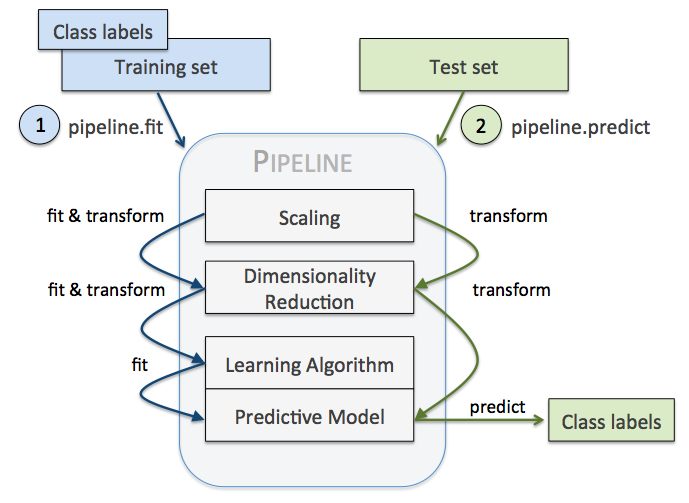

In [98]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe_model = Pipeline([
    ('scaler', StandardScaler()),
    ('features', PolynomialFeatures(degree = 2)),
    ('model', LogisticRegression(class_weight='balanced', C=2.0001))
])

In [99]:
pipe_model.fit(Xtrain, ytrain)

pred = pipe_model.predict(Xtest)

confusion_matrix(ytest, pred)

array([[2417, 1624],
       [ 184,  342]])

In [100]:
precision_score(ytest, pred), recall_score(ytest, pred), f1_score(ytest, pred)

(0.17395727365208546, 0.6501901140684411, 0.27447833065810595)

In [101]:
pipe_model2 = Pipeline([
    ('scaler', StandardScaler()),
    ('features', PolynomialFeatures()),
    ('model', LogisticRegression())
])

params = {'model__C' : np.arange(0.0001, 10.0001, 1),
          'model__class_weight' : [None, 'balanced'],
          'features__degree' : [2, 3, 4, 5]}

gs = GridSearchCV(pipe_model2, params, cv=3, scoring='f1', verbose=2)

gs.fit(Xtrain, ytrain)

gs.best_score_, gs.best_estimator_

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV] END features__degree=2, model__C=0.0001, model__class_weight=None; total time=   0.1s
[CV] END features__degree=2, model__C=0.0001, model__class_weight=None; total time=   0.0s
[CV] END features__degree=2, model__C=0.0001, model__class_weight=None; total time=   0.1s
[CV] END features__degree=2, model__C=0.0001, model__class_weight=balanced; total time=   0.1s
[CV] END features__degree=2, model__C=0.0001, model__class_weight=balanced; total time=   0.0s
[CV] END features__degree=2, model__C=0.0001, model__class_weight=balanced; total time=   0.1s
[CV] END features__degree=2, model__C=1.0001, model__class_weight=None; total time=   0.2s
[CV] END features__degree=2, model__C=1.0001, model__class_weight=None; total time=   0.2s
[CV] END features__degree=2, model__C=1.0001, model__class_weight=None; total time=   0.2s
[CV] END features__degree=2, model__C=1.0001, model__class_weight=balanced; total time=   0.2s
[CV] END fea

(0.2669467760171296, Pipeline(steps=[('scaler', StandardScaler()),
                 ('features', PolynomialFeatures()),
                 ('model',
                  LogisticRegression(C=9.0001, class_weight='balanced'))]))

In [102]:
model = gs.best_estimator_

model.fit(Xtrain, ytrain)

pred = model.predict(Xtest)

confusion_matrix(ytest, pred)

array([[2413, 1628],
       [ 185,  341]])

In [103]:
precision_score(ytest, pred), recall_score(ytest, pred), f1_score(ytest, pred)

(0.17318435754189945, 0.6482889733840305, 0.2733466933867736)